<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_3/Figure_3a/3_human_SARSCoV_validation_smartseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation using SARS-CoV2 infected human iPSC derived cardiomyocytes
Data from https://www.cell.com/cell-reports-medicine/pdf/S2666-3791(20)30068-9.pdf:

In [1]:
# Number of threads to use during alignments
threads = 2

## Install software

In [2]:
!pip install -q ffq gget kb_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 62.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.4 MB/s eta 

## Download SMART-Seq data

In [3]:
import json
import glob

# Get ftp download links for raw data with ffq and store results in json file
!ffq SRR11777734 SRR11777735 SRR11777736 SRR11777737 SRR11777738 SRR11777739 \
    --ftp \
    -o ffq.json

# Load ffq output
f = open("ffq.json")
data_json = json.load(f)
f.close()

# Download raw data using FTP links fetched by ffq
for dataset in data_json:
    url = dataset["url"]
    !curl -O $url

[2023-12-10 06:14:50,174]    INFO Parsing run SRR11777734
[2023-12-10 06:14:52,390]    INFO Parsing run SRR11777735
[2023-12-10 06:14:54,659]    INFO Parsing run SRR11777736
[2023-12-10 06:14:56,933]    INFO Parsing run SRR11777737
[2023-12-10 06:14:58,844]    INFO Parsing run SRR11777738
[2023-12-10 06:15:00,906]    INFO Parsing run SRR11777739
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2962M  100 2962M    0     0  43.4M      0  0:01:08  0:01:08 --:--:-- 43.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2634M  100 2634M    0     0  38.6M      0  0:01:08  0:01:08 --:--:-- 39.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2484M  100 2484M

## Download optimized PalmDB reference files


In [4]:
# Download the ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

--2023-12-10 06:22:31--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.1s    

2023-12-10 06:22:31 (148 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]

--2023-12-10 06:22:31--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

## Build virus reference index from PalmDB amino acid sequences and mask host (here, human) sequences
You can find the kb manual and tutorials [here](https://www.kallistobus.tools/).

The --aa argument tells kb that this is an amino acid reference.

The --d-list argument is the path to the host transcriptome. These sequences will be masked in the index. Here, we are using gget to fetch the human genome and transcriptome (release 110).

We are using --workflow custom here since we do not have a .gtf file for the PalmDB fasta file.

Building the index will take some time (~20 min), since the human genomes is quite large.

In [5]:
!gget ref -r 110 -w cdna,dna -d human

Sun Dec 10 06:22:41 2023 INFO Fetching reference information for homo_sapiens from Ensembl release: 110.
{
    "homo_sapiens": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz",
            "ensembl_release": 110,
            "release_date": "2023-04-22",
            "release_time": "04:25",
            "bytes": "75M"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz",
            "ensembl_release": 110,
            "release_date": "2023-04-21",
            "release_time": "17:28",
            "bytes": "841M"
        }
    }
}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75.2M  100 75.2M    0     0   631k      0  0:02:02  0:02:02 --:--:--  642k
  % Total    

In [6]:
# Concatenate human genome and transcriptome into one file
!cat Homo_sapiens.GRCh38.cdna.all.fa.gz Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz > Homo_sapiens.GRCh38.cdna_dna.fa.gz

In [7]:
%%time
!kb ref \
  --workflow custom \
  --aa \
  --d-list Homo_sapiens.GRCh38.cdna_dna.fa.gz \
  -t $threads \
  -i index.idx \
  palmdb_rdrp_seqs.fa

[2023-12-10 06:47:34,237]    INFO [ref_custom] Indexing palmdb_rdrp_seqs.fa to index.idx
[2023-12-10 08:38:30,360]    INFO [ref_custom] Finished creating custom index
CPU times: user 30.5 s, sys: 3.88 s, total: 34.3 s
Wall time: 1h 51min 7s


## Align data using kallisto translated search

Get fastq files:

In [8]:
fastqs = []
for filename in glob.glob("*.fastq.gz"):
    fastqs.append(filename.split("/")[-1])

fastqs.sort()
fastqs

['SRR11777734.fastq.gz',
 'SRR11777735.fastq.gz',
 'SRR11777736.fastq.gz',
 'SRR11777737.fastq.gz',
 'SRR11777738.fastq.gz',
 'SRR11777739.fastq.gz']

Loop over files and align one at a time (alternative: use a batch file to align multiple fastqs at the same time). The `-x` techology tells kb where to find the barcode and UMI in the data. We will treat the SMART-Seq data like bulk data for this validation.

In [9]:
%%time
for fastq in fastqs:
    sample = fastq.split(".fastq.gz")[0]

    !kb count \
        --aa \
        -t $threads \
        -i index.idx \
        -g palmdb_clustered_t2g.txt \
        -x bulk \
        --parity single \
        -o $sample \
        $fastq

[2023-12-10 08:38:43,447]    INFO [count] Using index index.idx to generate BUS file to SRR11777734 from
[2023-12-10 08:38:43,447]    INFO [count]         SRR11777734.fastq.gz
[2023-12-10 10:45:42,789]    INFO [count] Sorting BUS file SRR11777734/output.bus to SRR11777734/tmp/output.s.bus
[2023-12-10 10:45:44,993]    INFO [count] Inspecting BUS file SRR11777734/tmp/output.s.bus
[2023-12-10 10:45:46,096]    INFO [count] Generating count matrix SRR11777734/counts_unfiltered/cells_x_genes from BUS file SRR11777734/tmp/output.s.bus
[2023-12-10 10:45:47,705]    INFO [count] Writing gene names to file SRR11777734/counts_unfiltered/cells_x_genes.genes.names.txt
[2023-12-10 10:45:47,983] WARNING [count] 99228 gene IDs do not have corresponding valid gene names. These genes will use their gene IDs instead.
[2023-12-10 10:45:57,028]    INFO [count] Using index index.idx to generate BUS file to SRR11777735 from
[2023-12-10 10:45:57,028]    INFO [count]         SRR11777735.fastq.gz
[2023-12-10 12:

## Plot virus counts

In [10]:
!pip install -q kb_python

import kb_python.utils as kb_utils
import anndata
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors
%config InlineBackend.figure_format='retina'

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

In [11]:
u_tax_csv = "ID_to_taxonomy_mapping.csv"

Create adata objects from count matrices (since we did not use the `--h5ad` argument when running `kb count`, we will construct the AnnData objects from the raw matrix files):

In [13]:
adatas = []
for fastq in fastqs:
    # Load data
    sample = fastq.split(".fastq.gz")[0]

    # Filepath to counts
    X = f"{sample}/counts_unfiltered/cells_x_genes.mtx"
    # Filepath to barcode metadata
    var_path = f"{sample}/counts_unfiltered/cells_x_genes.genes.txt"
    # Filepath to gene metadata
    obs_path = f"{sample}/counts_unfiltered/cells_x_genes.barcodes.txt"

    # Create AnnData object
    adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

    # Add sample name
    adata.obs["sample"] = sample

    # Append to adata list
    adatas.append(adata)

In [14]:
adata = anndata.concat(adatas, merge="same")
# Set sample as index
adata.obs = adata.obs.set_index("sample")
adata.obs

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


""
sample
SRR11777734
SRR11777735
SRR11777736
SRR11777737
SRR11777738
SRR11777739


In [15]:
tax_df = pd.read_csv(u_tax_csv)
tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
404,u889,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
405,u9015,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
406,u944,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
407,u9771,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA


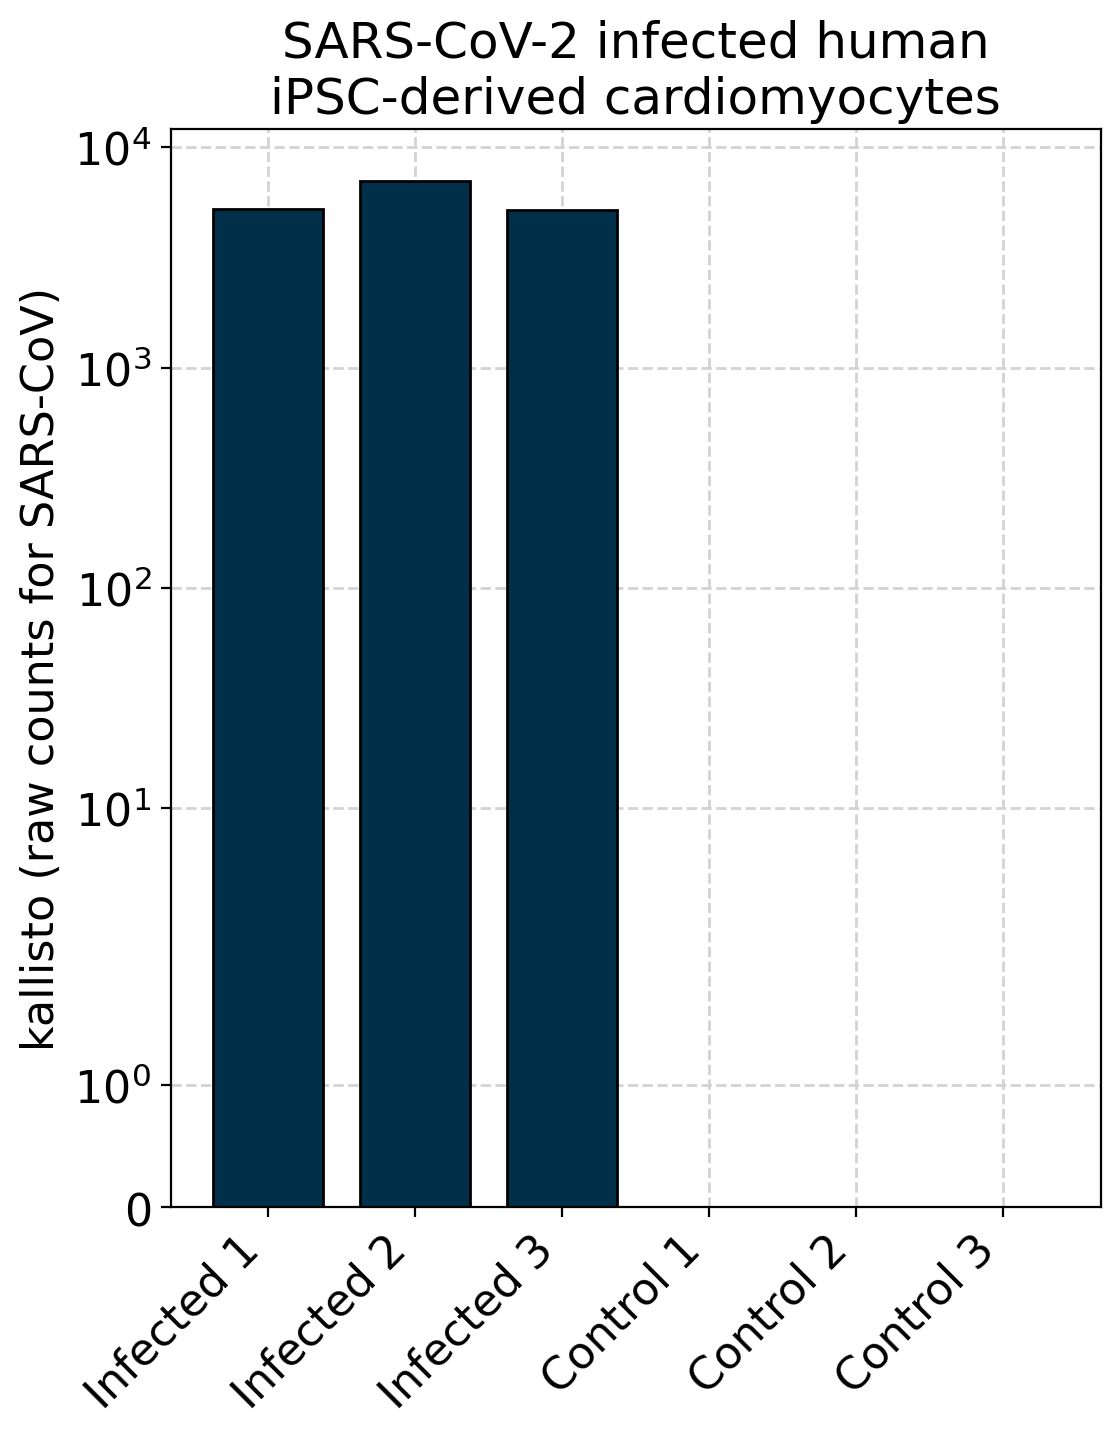

In [16]:
fig, ax = plt.subplots(figsize=(6, 7))
fontsize = 16
width = 0.75

x_labels = ['Infected 1', 'Infected 2', 'Infected 3', 'Control 1', 'Control 2', 'Control 3']

target_ids = tax_df[tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["rep_ID"].unique()

counts = []
samples = adata.obs.index.values
labels = samples
for sample in samples:
    counts.append(adata.X[adata.obs.index == sample, adata.var.index.isin(target_ids)].sum())

x = np.arange(len(labels))

ax.bar(x, counts, width=width, color="#003049", edgecolor="black")

ax.set_yscale("symlog")
ax.set_ylabel("kallisto (raw counts for SARS-CoV)", fontsize=fontsize)
# ax.set_xlabel("Sample", fontsize=fontsize)

ax.set_xticks(x, x_labels, rotation=45, ha="right")

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"SARS-CoV-2 infected human\niPSC-derived cardiomyocytes", fontsize=fontsize+2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# plt.tight_layout()

plt.savefig("smartseq_benchmark_PRJNA631969.png", dpi=300, bbox_inches="tight")

fig.show()

In [17]:
counts

[5265.0, 7037.0, 5187.0, 0.0, 0.0, 0.0]